# Compare PPP values for ESM4 and ESM2M

In [1]:
import xarray as xr
import esm4ppe
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

## Load data

In [2]:
basedir = '/work/gam/projects/'
localdir = '/data/processed/verify/verify.metric-ppp'
esm2mgridpath = basedir+'esm2m_ppe/data/ocean.static.nc'

In [3]:
names = {'esm4':{'intpp':'intpp','geolat':'geolat','geolon':'geolon','areacello':'areacello'},
         'esm2m':{'intpp':'NPP','geolat':'geolat_t','geolon':'geolon_t','areacello':'area_t'}}
thresholds = {'esm4':0.236,
              'esm2m':0.183}
colors = {'esm4':'tab:blue',
          'esm2m':'tab:orange'}

In [4]:
variable = 'intpp'
frequency = 'monthly'

In [5]:
grids = {'esm4':esm4ppe.open_static(variable,frequency),
         'esm2m':xr.open_dataset(esm2mgridpath)}

In [6]:
dd = {}
dg = {}
models = ['esm4','esm2m']

for model in models:
    fulldir = basedir+model+'_ppe'+localdir
    if model == 'esm4':
        fulldir+='.groupby-month'
    filename = names[model][variable]+'.monthly.nc'
    path = fulldir+'/'+filename
    dd[model]=xr.open_dataset(path)
    if model == 'esm4':
        dd[model]=dd[model].isel(month=0)
    # Set esm2m dims to lower case (to match grid)
    if model == 'esm2m':
        n = {k:k.lower() for k in dd[model].coords}
        dd[model]=dd[model].rename(n)

/vftmp/Graeme.Macgilchrist/pid7890/ipykernel_20652/3276019056.py:17: UserWarning: rename 'lead' to 'lead' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dd[model]=dd[model].rename(n)


## Plot map of both models at specific lead time

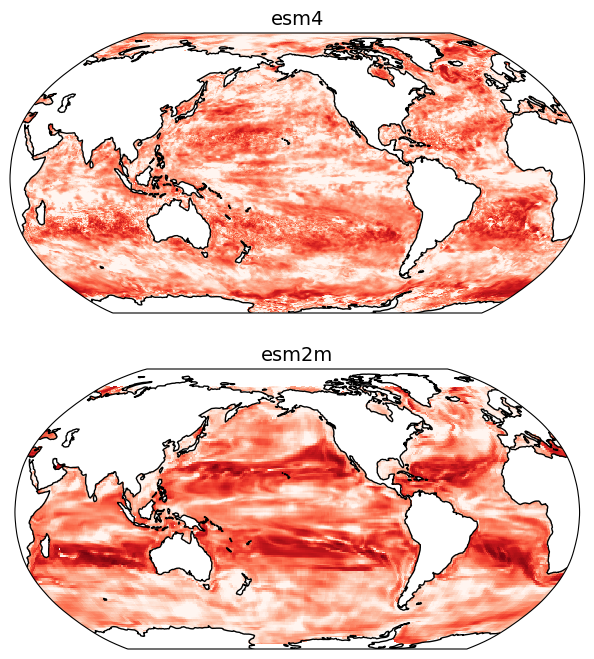

In [7]:
t = 12
fig,ax = plt.subplots(nrows=len(models),
                      figsize=(12,4*len(models)),
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=-150)})
for i,model in enumerate(models):
    axnow = ax.flat[i]
    axnow.coastlines()
    x = grids[model][names[model]['geolon']]
    y = grids[model][names[model]['geolat']]
    z = dd[model][names[model][variable]].isel(lead=t)
    im = axnow.pcolormesh(x,y,z,transform=ccrs.PlateCarree(),
                         cmap='Reds')
    im.set_clim([0,1])
    axnow.set_title(model,fontsize=14)

## Calculate and plot global mean value of PPP

In [8]:
dd_ga = {}
for model in models:
    area = grids[model][names[model]['areacello']].fillna(0)
    dims = [d for d in dd[model].dims if d != 'lead']
    dd_ga[model] = dd[model].weighted(area).mean(dims)

(0.0, 120.0)

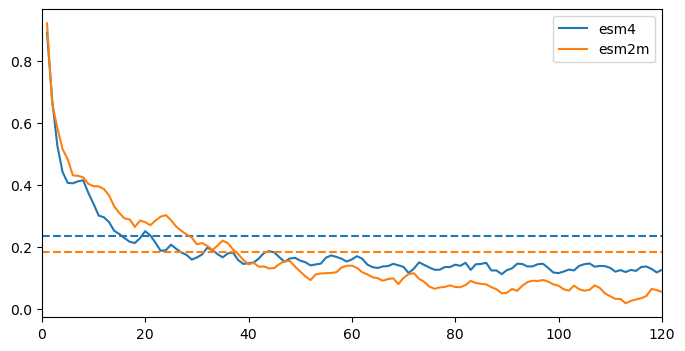

In [9]:
fig,ax = plt.subplots(figsize=(8,4))
for model in models:
    x = dd_ga[model]['lead']
    y = dd_ga[model][names[model][variable]]
    im = ax.plot(x,y,color=colors[model],label=model)
    ax.axhline(thresholds[model],color=colors[model],linestyle='--')
ax.legend()
ax.set_xlim([0,120])